## Imports

In [1]:
## Uncomment only on colab
# !pip install transformers evaluate
# !git clone https://github.com/DanielSc4/Approach-LWD.git
# %cd Approach-LWD/src

In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# from torch.utils.data import Dataset
from models.CustomDatasetBinary import CustomDatasetBinary
from torch.utils.data import DataLoader

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
### models_name = 'bert-base-uncased'

### BERT
# models_name = 'bert-base-uncased'
### RoBERTa
model_name = 'roberta-base'
torch_dtype = torch.bfloat16

In [4]:
# selecting device based on whats available
device = ''
if torch.cuda.is_available():
    print('Using GPU')
    device = 'cuda'
# Only on torch night for Apple M1 GPU
elif torch.backends.mps.is_available():
    print('Using MPS (Apple Silicon GPU)')
    device = 'mps'
else:
    print('Using CPU, :(')
    device = 'cpu'

Using MPS (Apple Silicon GPU)


## Datasets & loaders

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# starting w/ MD dataset
df = pd.read_csv('../data/MD_LoD.csv', index_col = 0)
df

# exclude labels == 2 (slightly agreement)
df = df[df['disagreement_lev'] != 2]
# shuffle dataser
df = df.sample(frac=1)


BATCH_SIZE = 22

train_set = CustomDatasetBinary(df[df['split'] == 'train'], tokenizer, label_col = 'disagreement_lev', dtype = torch_dtype)
val_set = CustomDatasetBinary(df[df['split'] == 'dev'], tokenizer, label_col = 'disagreement_lev', dtype = torch_dtype)
test_set = CustomDatasetBinary(df[df['split'] == 'test'], tokenizer, label_col = 'disagreement_lev', dtype = torch_dtype)


# ############ only to overfit a batch (test to check model's correctness)
# fake_df = pd.concat(
#     [df[:BATCH_SIZE]] * 1   # concat the same batch multiple times
# )
# train_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# val_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# test_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# print(f'----------\n|-> Using fake_df: size {len(fake_df)}\n----------')
# print(f'Label distr: \n{fake_df["disagreement_lev"].value_counts()}\n')
# ############ comment this section to train on the entire data available


print(f'len: \n\tTrain: {len(train_set)}\n\tVal: {len(val_set)}\n\tTest: {len(test_set)}')

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)

len: 
	Train: 4662
	Val: 787
	Test: 2148


## Model from Hugging Face

In [13]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /Users/daniel/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
print(type(dataset))
next(iter(dataset['train']))

<class 'datasets.dataset_dict.DatasetDict'>


{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [27]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

d = {
    'train': Dataset.from_dict({'label': df[df['split'] == 'train']['disagreement_lev'], 'text': df[df['split'] == 'train']['text']}),
    'val': Dataset.from_dict({'label': df[df['split'] == 'dev']['disagreement_lev'], 'text': df[df['split'] == 'dev']['text']}),
    'test': Dataset.from_dict({'label': df[df['split'] == 'test']['disagreement_lev'], 'text': df[df['split'] == 'test']['text']}),
}

d = DatasetDict(d)


from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = d.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

Map:   0%|          | 0/4662 [00:00<?, ? examples/s]

Map:   0%|          | 0/787 [00:00<?, ? examples/s]

Map:   0%|          | 0/2148 [00:00<?, ? examples/s]

In [28]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

import evaluate
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset= small_train_dataset,
    eval_dataset= small_eval_dataset,
    compute_metrics = compute_metrics,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [29]:
trainer.train()

/Users/daniel/miniforge3/envs/torch_new/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1749 [00:00<?, ?it/s]

## Model

In [6]:
from models.TransformerBinaryClassifier import TransformerBinaryClassifier

from transformers import AutoModel
transformer_model = AutoModel.from_pretrained(model_name, torch_dtype = torch_dtype)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# test
tokenizer(
    ['hello my name is Daniel', 'hello my name is Roberta'],
    padding = 'max_length', 
    max_length = 20, 
    truncation = True,
    return_tensors = "pt",
)

{'input_ids': tensor([[    0, 42891,   127,   766,    16,  3028,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0, 42891,   127,   766,    16,  1738,   102,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [8]:
# input of the model: 
#   input_ids
#   attention_mask
model = TransformerBinaryClassifier(
    model = transformer_model,
    dropout_rate = .0,
)
# inp, lbl = next(iter(train_loader))
# out = model(
#     inp['input_ids'],
#     inp['attention_mask'],
# )
# print(out.shape)
# out.reshape(len(out)).shape


In [9]:
from models.utils import train_loop
import torch.nn as nn

from torch.optim import Adam
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 3e-3)

history = train_loop(
    epochs = 6, 
    model = model, 
    device = device, 
    train_loader = train_loader, 
    val_loader = val_loader, 
    optimizer = optimizer, 
    criterion = criterion,
    log_freq = len(train_loader) // 10, 
    dtype = torch_dtype,
    name = 'test2',
)

-- Epoch 01 --
tensor([0.5032, 0.5018, 0.5049, 0.5009, 0.5027, 0.5031, 0.5003, 0.4960, 0.5004,
        0.5003, 0.5039], device='mps:0', grad_fn=<ReshapeAliasBackward0>)
   01) [train,     1] 	loss: 0.694
tensor([0.4765, 0.4952, 0.4907, 0.4663, 0.4743, 0.4619, 0.4593, 0.4986, 0.4453,
        0.4810, 0.4486], device='mps:0')
   01) [eval,     1] 	loss: 0.662
   [Recap 01 epoch] - train_loss: 0.694, train_acc: 0.3636 | eval_loss: 0.662, eval_acc: 0.5455 | elapsed time: 1.6s	 <-- Best epoch so far, val	 <-- Best epoch so far, acc

-- Epoch 02 --
tensor([0.4824, 0.4982, 0.4916, 0.4675, 0.4834, 0.4741, 0.3506, 0.4958, 0.3399,
        0.4873, 0.4570], device='mps:0', grad_fn=<ReshapeAliasBackward0>)
   02) [train,     1] 	loss: 0.631
tensor([0.4438, 0.4933, 0.4840, 0.3762, 0.4507, 0.4036, 0.3754, 0.4980, 0.3604,
        0.4676, 0.3657], device='mps:0')
   02) [eval,     1] 	loss: 0.603
   [Recap 02 epoch] - train_loss: 0.631, train_acc: 0.5455 | eval_loss: 0.603, eval_acc: 0.5455 | elapsed ti

### Plot

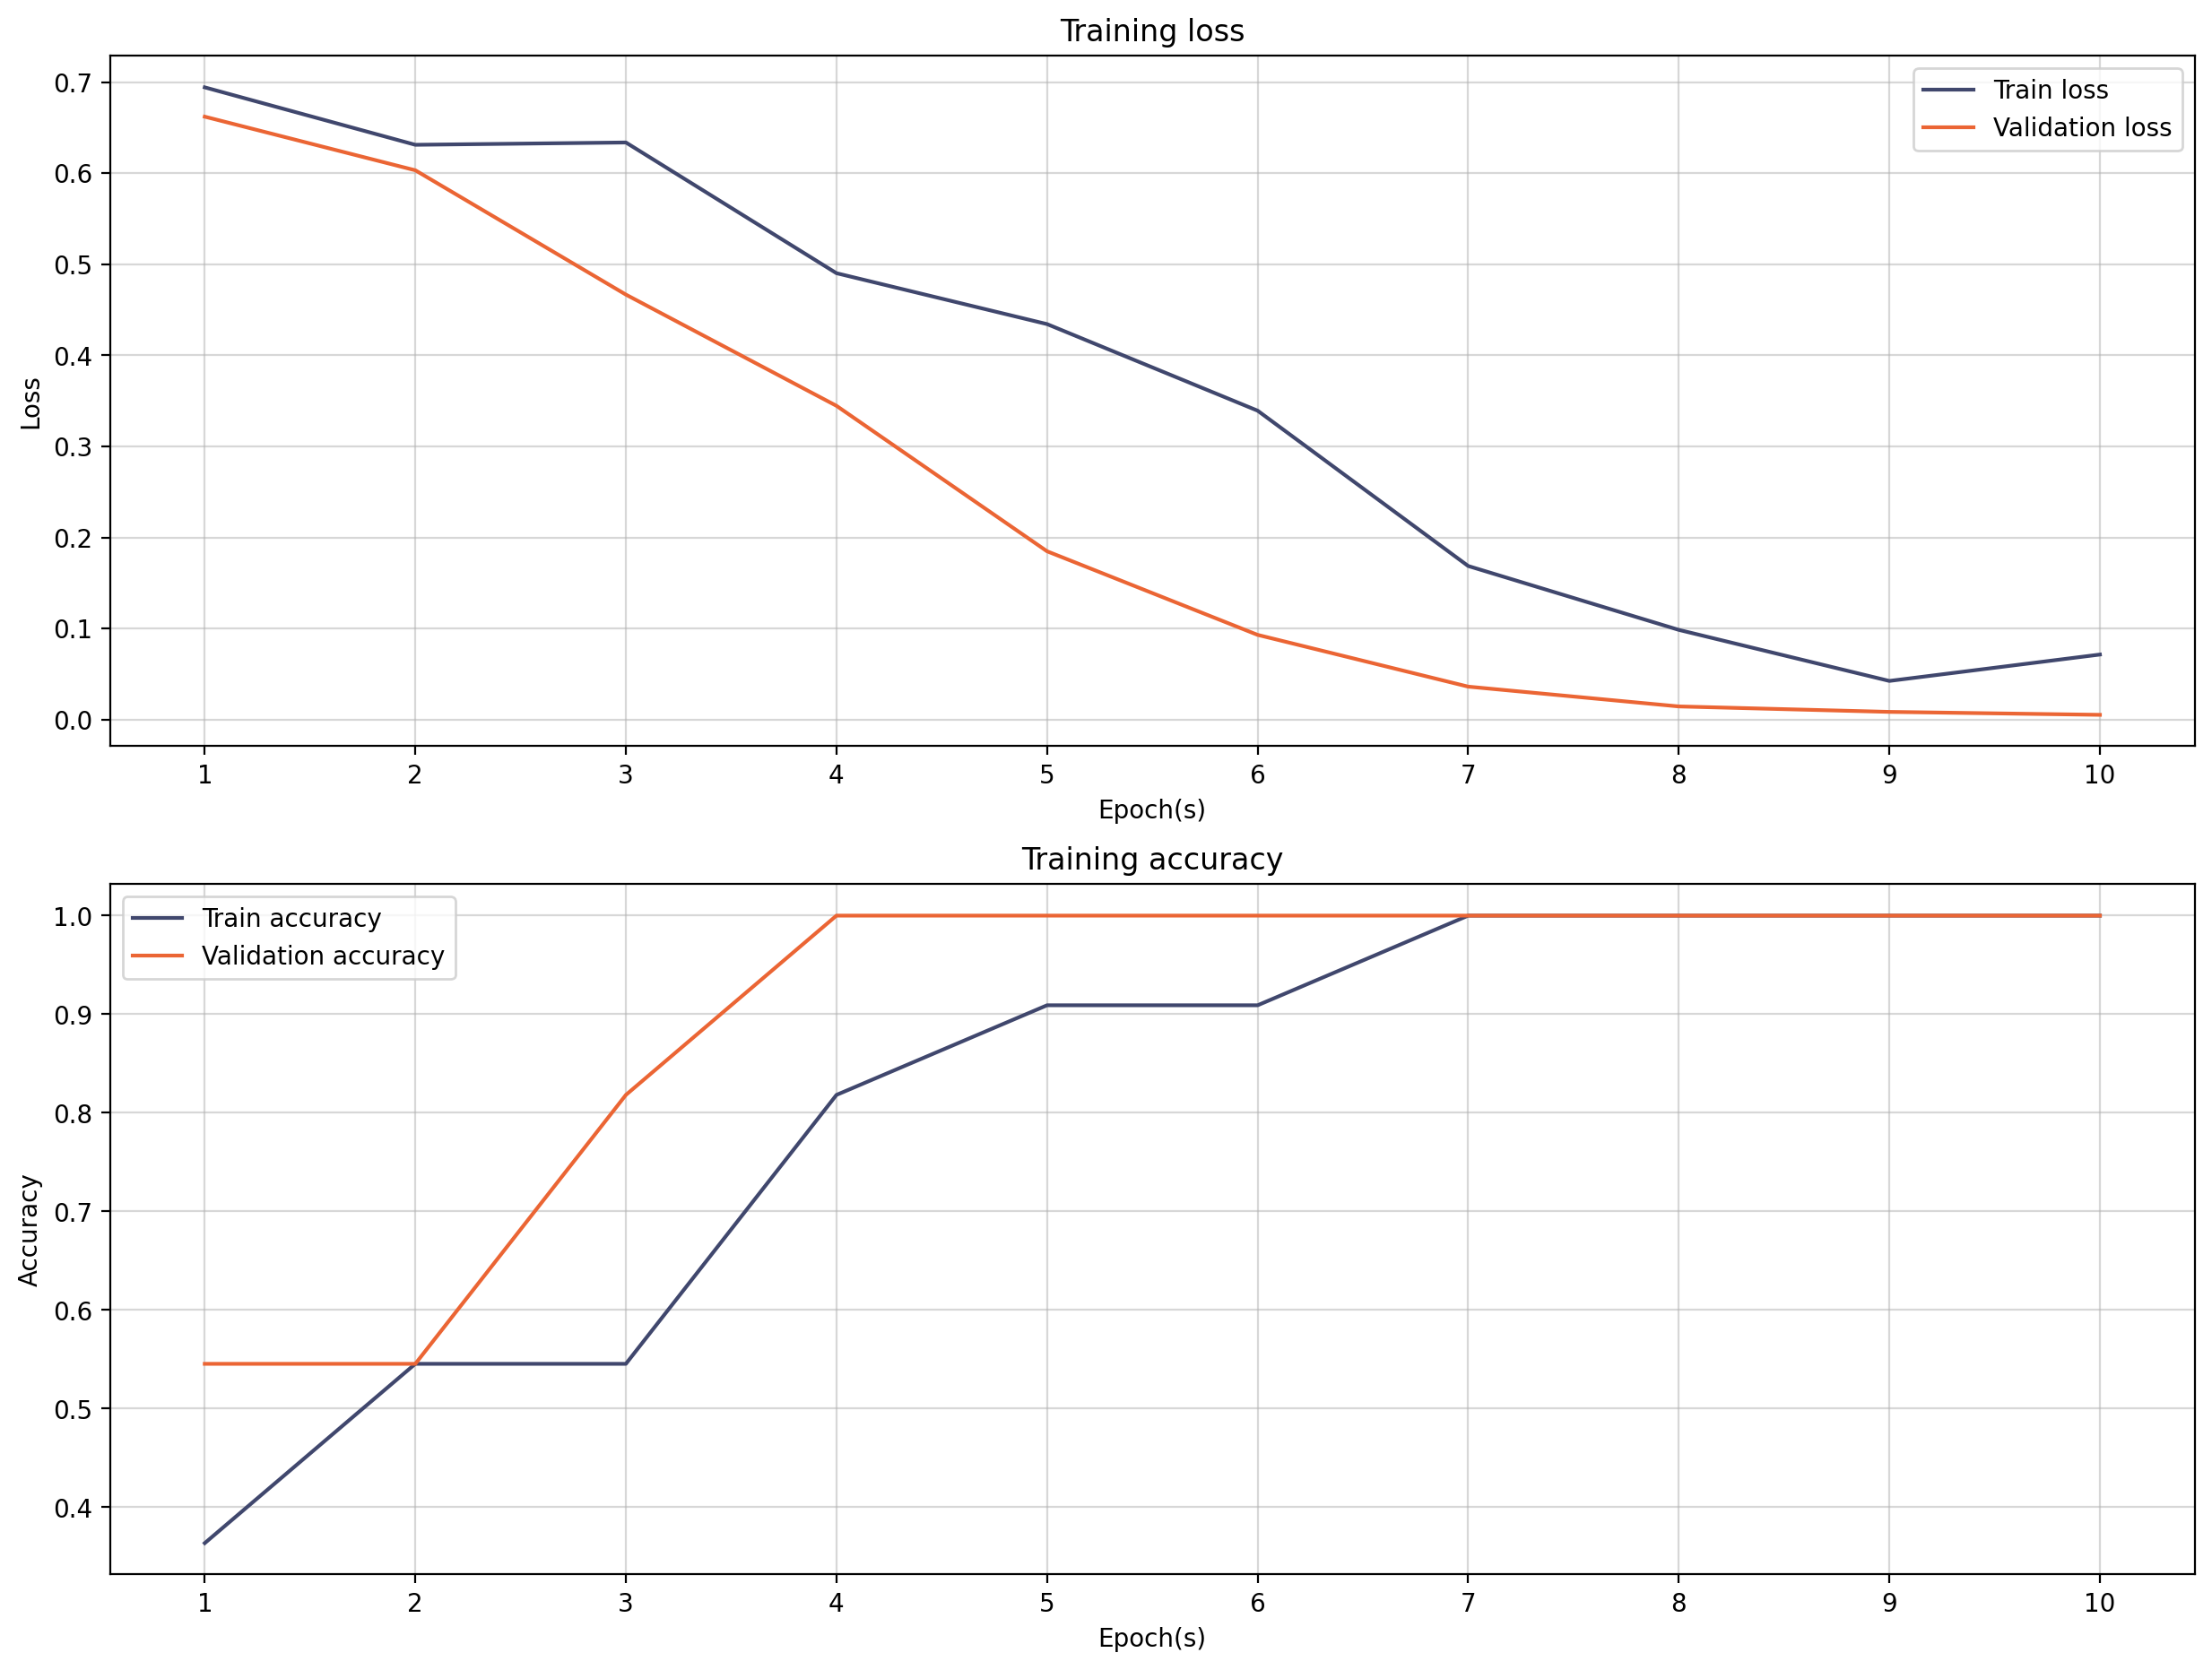

In [11]:
palette = {
    0: '#ACBEA3', 
    1: '#40476D', 
    2: '#826754', 
    3: '#EB6534',
    4: '#AD5D4E'
}
plt.figure(figsize= (15, 11), dpi = 200)

plt.subplot(2, 1, 1)
x = np.arange(len(history['train_losses'])) + 1
plt.xticks(x)
plt.plot(x, history['train_losses'], label = 'Train loss', color = palette[1])
plt.plot(x, history['val_losses'], label = 'Validation loss', color = palette[3])
plt.title('Training loss')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.grid(alpha = .5)
plt.legend()

plt.subplot(2, 1, 2)
plt.xticks(x)
plt.plot(x, history['train_accs'], label = 'Train accuracy', color = palette[1])
plt.plot(x, history['val_accs'], label = 'Validation accuracy', color = palette[3])
plt.title('Training accuracy')
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
plt.grid(alpha = .5)
plt.legend()

plt.show()

In [12]:
# tmp store
import pickle
with open('backup_history1.pkl', 'wb') as f:
    pickle.dump(history, f)

## Test

In [15]:
from models.utils import compute_acc

test_model = history['final_model'].to(device)

test_model.eval()
test_accs = .0

tot_outputs = []
tot_pred = []

for inputs, labels in test_loader:
    for ele in inputs:
            inputs[ele] = inputs[ele].to(device)
    labels = labels.to(device)
    with torch.no_grad():
          outputs = test_model(
                inputs['input_ids'],
                inputs['attention_mask'],
            ).reshape(len(labels))
    test_accs += compute_acc(outputs, labels)
    tot_outputs.extend([int(x) for x in outputs.round().flatten().tolist()])
    tot_pred.extend([int(x) for x in labels.round().flatten().tolist()])

print(f'Final accuracy: {test_accs / len(test_loader)}')

Final accuracy: 1.0


In [17]:
from sklearn.metrics import classification_report

print(classification_report(tot_outputs, tot_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



## TODO
 - transfer learning su roberta (```require_grad = False``` on LM
)